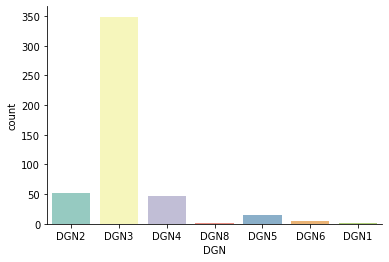

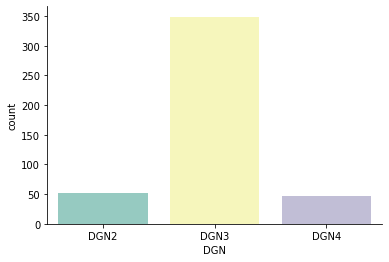

In [1]:
%run 'preprocessing/preprocessingv1.0.ipynb'

In [2]:
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np 
import pandas as pd
import seaborn as sns 
sns.set_style('white')
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback
import tensorflow as tf 
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # for gradient warning (variables are still updated, therefore supressing is fine)
import tensorflow_probability as tfp 
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input
from tensorflow.keras.losses import Loss

tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

color_list = ['#bcad', '#dacb']

### Define prior distribution

In [3]:
def get_prior(num_modes, latent_dim):
    
    mixture_distribution = tfd.Categorical(probs=[1./num_modes] * num_modes)
    components_distribution = tfd.MultivariateNormalDiag(loc=tf.Variable(tf.random.normal((num_modes, latent_dim))),
                                                        scale_diag=tfp.util.TransformedVariable(tf.ones((num_modes,latent_dim)),
                                                                                               bijector=tfb.Softplus())
                                                        )
    prior = tfd.MixtureSameFamily(mixture_distribution,
                                  components_distribution
                                 )
    return prior

In [4]:
latent_dim = len(X_train.columns)
input_shape = len(X_train.columns)

prior = get_prior(num_modes=latent_dim, latent_dim=input_shape) 
print(f'Prior event shape: {prior.event_shape[0]}')
print(f'# of Gaussions: {prior.components_distribution.batch_shape[0]}') 
print(f'Covariance matrix: {prior.components_distribution.name}')

Prior event shape: 16
# of Gaussions: 16
Covariance matrix: MultivariateNormalDiag


### Define KL divergence

In [5]:
# set weight for more emphasis on KLDivergence term rather than reconstruction loss
# average over both samples and batches

def get_KL_regularizer(prior, weight=4.):
    
    regularizer = tfpl.KLDivergenceRegularizer(prior, 
                                        use_exact_kl=False,
                                        test_points_reduce_axis=(),
                                        test_points_fn=lambda q: q.sample(10),
                                        weight=weight
                                        )
    return regularizer

In [6]:
KLDivergence_regularizer = get_KL_regularizer(prior)

### Define the encoder

In [7]:
def get_encoder(input_shape, latent_dim, KL_regularizer):
    
    encoder = Sequential([
        Dense(input_shape=input_shape, units=256, activation='relu'),
        Dense(units=128, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=32, activation='relu'),
        Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
        tfpl.MultivariateNormalTriL(latent_dim, 
                                   activity_regularizer=KL_regularizer),
    ])
    
    return encoder

In [8]:
encoder = get_encoder(input_shape=(input_shape,), latent_dim=latent_dim, KL_regularizer=KLDivergence_regularizer)
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               4352      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 152)               5016      
_________________________________________________________________
multivariate_normal_tri_l (M multiple                  512       
Total params: 53,112
Trainable params: 53,112
Non-trainable params: 0
____________________________________________________

### Define the decoder 

In [9]:
def get_decoder(latent_dim):
    
    decoder = Sequential([
        Dense(input_shape=(latent_dim,), units=5, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=128, activation='relu'),
        Dense(units=256, activation='relu'),
        Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
        tfpl.MultivariateNormalTriL(latent_dim)
    ])
    
    return decoder

In [10]:
decoder = get_decoder(latent_dim)
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 5)                 85        
_________________________________________________________________
dense_6 (Dense)              (None, 64)                384       
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_8 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_9 (Dense)              (None, 152)               39064     
_________________________________________________________________
multivariate_normal_tri_l_1  multiple                  0         
Total params: 80,877
Trainable params: 80,877
Non-trainable params: 0
__________________________________________________

### Connect encoder to decoder 

In [11]:
vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))
vae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_input (InputLayer)     [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 256)               4352      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 152)               5016      
_________________________________________________________________
multivariate_normal_tri_l (M multiple                  512   

### Specify the loss function 

In [12]:
# KL divergence is implicity incorporated to the loss function before
# add reconstruction error to loss function 
def reconstruction_error(decoding_dist, x_true):
    return -tf.reduce_mean(decoding_dist.log_prob(x_true))

class custom_reconstruction_error(Loss):
    def call(self, decoding_dist, x_true):
        return -tf.reduce_mean(decoding_dist.log_prob(x_true))

### Selection process

In [13]:
print(f'# of training samples: {X_train.shape[0]}')
print(f'# of test samples: {X_test.shape[0]}')

# of training samples: 300
# of test samples: 148


In [14]:
X_train_prior_visual = pd.DataFrame(scaler.inverse_transform(X_train), columns=X_train.columns).astype('int64')
y_train.reset_index(drop=True, inplace=True)
X_train_prior_visual['Risk1Yr'] = y_train

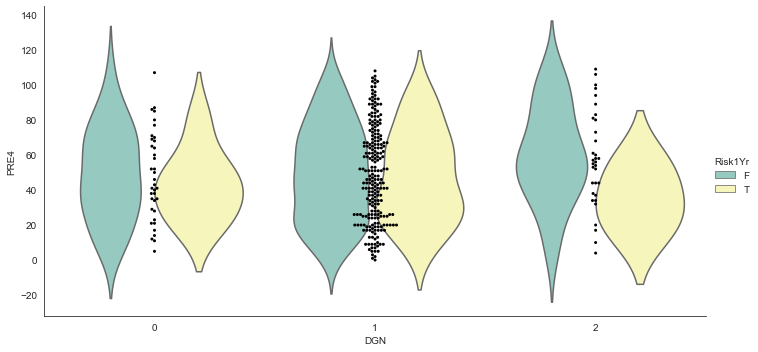

In [15]:
g = sns.catplot(x='DGN', y='PRE4', kind="violin", hue='Risk1Yr', data=X_train_prior_visual, inner=None, legend_out=True, doge=True, palette='Set3', aspect=2, ci=95)
sns.swarmplot(x="DGN", y='PRE4', color="k", size=3, data=X_train_prior_visual, ax=g.ax)
sns.despine()

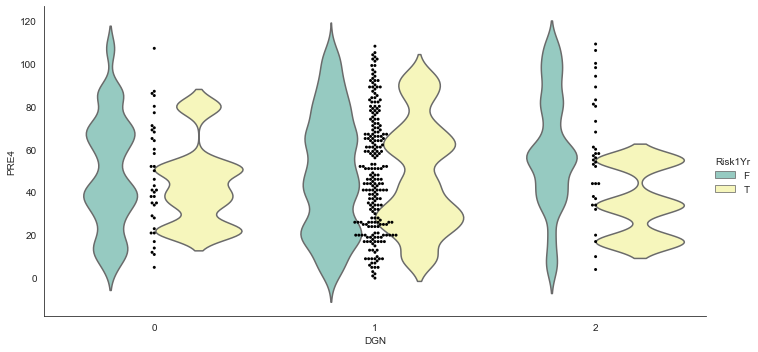

In [16]:
g = sns.catplot(x='DGN', y='PRE4', kind="violin", hue='Risk1Yr', data=X_train_prior_visual, inner=None, doge=True, palette='Set3', legend_out=True, aspect=2, bw=0.2, ci=95)
sns.swarmplot(x="DGN", y='PRE4', color="k", size=3, data=X_train_prior_visual, ax=g.ax)
sns.despine()

### Compile and fit the model 

In [17]:
optimizer = Adam(learning_rate=3e-4)
epochs = 1000 
epoch_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: print('\n Epoch {}/{}'.format(epoch+1, epochs, logs),
                                                                       '\n\t ' + (': {:.4f}, '.join(logs.keys()) + ': {:.4f}').format(*logs.values()))
                                if epoch % 100 == 0 else False
                               )


vae.compile(optimizer=optimizer, loss=reconstruction_error)
history = vae.fit(X_train, 
                  validation_data=(X_test,),
                  epochs=epochs, 
                  batch_size=32,
                  verbose=0,
                  shuffle=True,
                  callbacks=[epoch_callback]
                 )


 Epoch 1/1000 
	 loss: 412.1550, val_loss: 406.0995

 Epoch 101/1000 
	 loss: 34.0448, val_loss: 35.2328

 Epoch 201/1000 
	 loss: 13.7975, val_loss: 14.0460

 Epoch 301/1000 
	 loss: 6.4840, val_loss: 5.9566

 Epoch 401/1000 
	 loss: 3.3904, val_loss: 3.6168

 Epoch 501/1000 
	 loss: 2.1311, val_loss: 2.2261

 Epoch 601/1000 
	 loss: 1.4892, val_loss: 1.8160

 Epoch 701/1000 
	 loss: 0.9465, val_loss: 0.9693

 Epoch 801/1000 
	 loss: 0.6962, val_loss: 1.5155

 Epoch 901/1000 
	 loss: 0.7830, val_loss: 0.6719


### Plot training and validation losses 

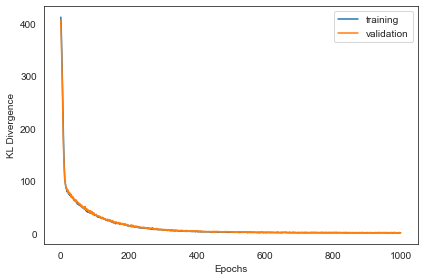

In [18]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('KL Divergence')
plt.tight_layout()
plt.show()

# Loss function is ELBO maximization
# ELBO maximization is equivalent to KL divergence minimization 

### Sample from the generative model

In [126]:
X_train_sample = encoder(X_train.to_numpy()).sample()
X_train_sample = pd.DataFrame(X_train_sample.numpy(), columns=X_test.columns)

In [127]:
X_train_sample.head()

,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE
0,2.407982,-0.831916,2.002110,-0.153428,0.954857,0.083955,0.436395,-2.078765,-1.488115,-0.231488,-0.061668,-0.949218,1.709186,-0.830009,2.592370,0.038623
1,2.054684,-2.579462,0.267117,-2.559943,0.820520,1.518479,-0.525705,-0.696743,0.276630,0.158306,-1.480168,0.939017,-1.205487,2.143132,0.010564,0.333124
2,-1.431643,-3.029876,0.148751,0.273040,0.946856,-2.778357,-1.209445,-0.415556,1.428541,1.260927,-0.324407,0.132441,-0.229503,0.225607,0.491041,-0.748245
3,-0.281104,-0.509333,1.997721,-1.335895,0.376429,0.630013,-1.233507,-0.079674,-1.723972,-2.168686,2.634992,0.437542,0.865715,-0.459556,0.774192,0.524889
4,0.376555,-1.034092,0.058366,1.709675,0.435779,-0.455206,-2.279676,0.541935,0.410181,0.310724,-0.937057,1.826935,0.648489,-0.013052,0.119601,-1.192695


In [128]:
# propogate back from the pipeline
# training data -- reverse standardization

X_train_sample = pd.DataFrame(scaler.inverse_transform(X_train_sample.to_numpy()), columns=X_train.columns)
X_train_sample = X_train_sample.astype('int64')
X_train_sample.head()

,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE
0,2,27,96,0,0,0,0,0,0,0,0,0,0,0,0,24
1,1,-19,51,0,0,0,0,0,0,0,0,0,0,1,0,27
2,0,-32,48,0,0,0,0,0,0,1,0,0,0,0,0,18
3,0,35,96,0,0,0,0,0,0,0,0,0,0,0,0,28
4,1,21,46,1,0,0,0,0,0,0,0,0,0,0,0,14


In [129]:
# propogate back from the pipeline
# testing data -- reverse standardization

X_test_sample = encoder(X_test.to_numpy()).sample()
X_test_sample = pd.DataFrame(X_test_sample.numpy(), columns=X_train.columns)

X_test_sample = pd.DataFrame(scaler.inverse_transform(X_test_sample.to_numpy()), columns=X_test.columns)
X_test_sample = X_test_sample.astype('int64')
X_test_sample.head()

,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE
0,0,20,30,0,0,0,0,0,0,0,0,0,0,1,0,17
1,0,51,68,0,0,0,0,0,0,0,0,0,0,0,0,18
2,1,48,41,0,0,0,0,0,0,0,0,0,0,1,0,19
3,0,15,58,0,0,0,0,1,0,-1,0,0,0,1,0,14
4,1,19,27,0,0,0,0,0,0,0,0,0,0,0,0,38


In [130]:
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True) # for concatenation

X_train_sample['Risk1Yr'] = y_train

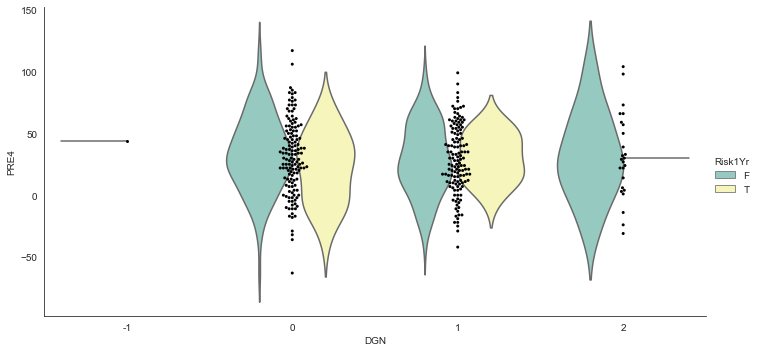

In [131]:
g = sns.catplot(x='DGN', y='PRE4', kind="violin", hue='Risk1Yr', data=X_train_sample, inner=None, legend_out=True, doge=True, palette='Set3', aspect=2, ci=95)
sns.swarmplot(x="DGN", y='PRE4', color="k", size=3, data=X_train_sample, ax=g.ax)
sns.despine()

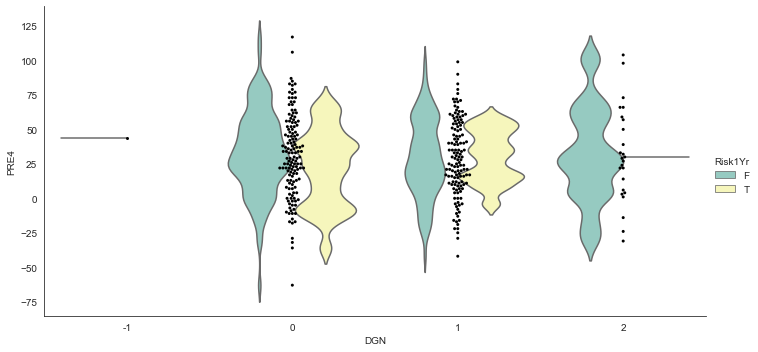

In [132]:
g = sns.catplot(x='DGN', y='PRE4', kind="violin", hue='Risk1Yr', data=X_train_sample, inner=None, doge=True, palette='Set3', legend_out=True, aspect=2, bw=0.2, ci=95)
sns.swarmplot(x="DGN", y='PRE4', color="k", size=3, data=X_train_sample, ax=g.ax)
sns.despine()

In [133]:
# decode 
X_train_sample.drop('Risk1Yr',axis=1,inplace=True)
X_train_sample = pd.DataFrame(scaler.inverse_transform(decoder(X_train_sample.to_numpy()).sample().numpy()), columns=X_train.columns)
X_train_sample = X_train_sample.astype('int64')
X_train_sample.head()

,DGN,PRE4,PRE5,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,AGE
0,1,7,69,1,0,2,0,1,0,4,0,0,0,0,0,26
1,1,46,0,0,0,0,0,1,0,0,0,0,0,0,0,9
2,1,41,24,0,0,0,0,0,0,1,0,0,0,0,0,11
3,1,49,42,4,-2,0,0,-6,-1,7,-1,0,0,5,0,-47
4,1,36,27,0,0,1,0,2,0,0,1,0,0,0,0,11


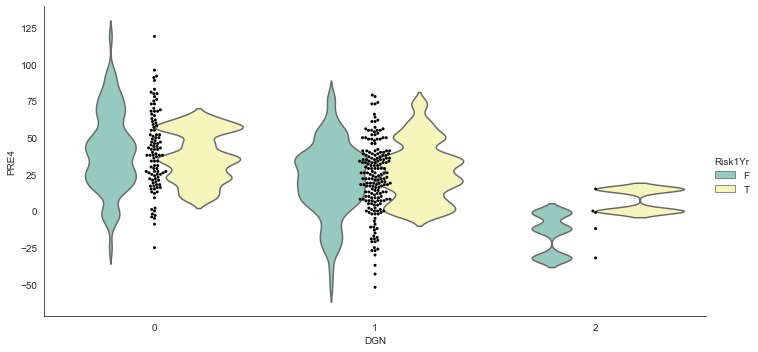

In [134]:
X_train_sample['Risk1Yr'] = y_train

g = sns.catplot(x='DGN', y='PRE4', kind="violin", hue='Risk1Yr', data=X_train_sample, inner=None, doge=True, palette='Set3', legend_out=True, aspect=2, bw=0.2, ci=95)
sns.swarmplot(x="DGN", y='PRE4', color="k", size=3, data=X_train_sample, ax=g.ax)
sns.despine()

### Masked Autoregressive Flow

In [135]:
X_train_sample.drop('Risk1Yr', axis=1, inplace=True) # drop target, was only intended for VAE sampling

In [136]:
loc = [X_train_sample[i].mean().astype('float32') for i in list(X_train.columns)]
scale_diag = [X_train_sample[i].std().astype('float32') for i in list(X_train.columns)]

In [137]:
mvn = tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale_diag)
mvn

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[16] dtype=float32>

In [138]:
def masked_autoregressive_flow(hidden_units=[16,16], event_shape=[16], activation='relu'):
    network = tfb.AutoregressiveNetwork(params=2, 
                                    hidden_units=hidden_units,
                                    event_shape=event_shape,
                                    activation=activation
                                   )
    return tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=network)

In [139]:
trainable_dist = tfd.TransformedDistribution(distribution=mvn,
                                             bijector=masked_autoregressive_flow(
                                             activation='sigmoid'))
trainable_dist

<tfp.distributions.TransformedDistribution 'masked_autoregressive_flowMultivariateNormalDiag' batch_shape=[] event_shape=[16] dtype=float32>

In [140]:
n_samples = 300
x = mvn.sample(sample_shape=n_samples)
names = [mvn.name, trainable_dist.bijector.name]
samples = [x, trainable_dist.bijector.forward(x)]

In [141]:
X_train_np = X_train_sample.to_numpy()
X_test_np = X_test_sample.to_numpy()

In [142]:
# standardize once again before feeding into network 
scaler.fit(X_train_np)
X_train_np = scaler.transform(X_train_np)
X_test_np = scaler.transform(X_test_np)

In [146]:
X_train = X_train_np.astype(np.float32)
X_train = tf.data.Dataset.from_tensor_slices(X_train)
X_train = X_train.batch(128)

X_valid = X_test_np.astype(np.float32)
X_valid = tf.data.Dataset.from_tensor_slices(X_valid)
X_valid = X_valid.batch(128)

In [147]:
num_epochs = 600
opt = tf.keras.optimizers.Adam(3e-4)
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    if epoch % 100 == 0:
        print("Epoch {}...".format(epoch))
    train_loss = tf.keras.metrics.Mean()
    val_loss = tf.keras.metrics.Mean()
    for train_batch in X_train:
        with tf.GradientTape() as tape:
            tape.watch(trainable_dist.bijector.trainable_variables)
            loss = -trainable_dist.log_prob(train_batch)
        train_loss(loss)
        grads = tape.gradient(loss, trainable_dist.bijector.trainable_variables)
        opt.apply_gradients(zip(grads, trainable_dist.bijector.trainable_variables))
    train_losses.append(train_loss.result().numpy())
        
    # Validation
    for valid_batch in X_valid:
        loss = -trainable_dist.log_prob(valid_batch)
        val_loss(loss)
    valid_losses.append(val_loss.result().numpy())

Epoch 0...
Epoch 100...
Epoch 200...
Epoch 300...
Epoch 400...
Epoch 500...


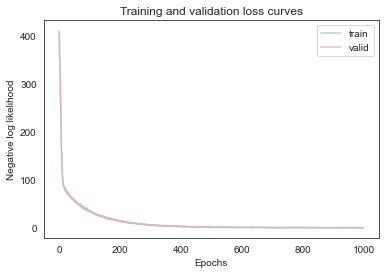

In [148]:
train_losses = history.history['loss']
valid_losses = history.history['val_loss']

plt.plot(train_losses, label='train', c=color_list[0])
plt.plot(valid_losses, label='valid', c=color_list[1])
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

In [149]:
x = mvn.sample(sample_shape=n_samples)
names = [mvn.name, trainable_dist.bijector.name]
samples = [x, trainable_dist.bijector.forward(x)]

In [162]:
num_layers = 4
flow_bijector = []

# set trainable=False for once and for all initialization 
def init_once(x):
    return tf.Variable(x, name='permutation', trainable=False)


for i in range(num_layers):
    flow_i = masked_autoregressive_flow(hidden_units=[256,256])
    flow_bijector.append(flow_i) 
    flow_bijector.append(tfb.Permute(init_once(x=np.random.permutation(16).astype('int'))))
# discard the last permute layer 
flow_bijector = tfb.Chain(list(reversed(flow_bijector[:-1])))

In [163]:
trainable_dist = tfd.TransformedDistribution(distribution=mvn,
                                            bijector=flow_bijector)

In [164]:
def make_samples():
    x = mvn.sample(n_samples)
    samples = [x]
    names = [mvn.name]
    for bijector in reversed(trainable_dist.bijector.bijectors):
        x = bijector.forward(x)
        samples.append(x)
        names.append(bijector.name)
    return names, samples

names, samples = make_samples()

In [165]:
num_epochs = 300
opt = tf.keras.optimizers.Adam(3e-4)
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    if epoch % 100 == 0:
        print("Epoch {}...".format(epoch))
    train_loss = tf.keras.metrics.Mean()
    val_loss = tf.keras.metrics.Mean()
    for train_batch in X_train:
        with tf.GradientTape() as tape:
            tape.watch(trainable_dist.bijector.trainable_variables)
            loss = -trainable_dist.log_prob(train_batch)
        train_loss(loss)
        grads = tape.gradient(loss, trainable_dist.bijector.trainable_variables)
        opt.apply_gradients(zip(grads, trainable_dist.bijector.trainable_variables))
    train_losses.append(train_loss.result().numpy())
        
    # Validation
    for valid_batch in X_valid:
        loss = -trainable_dist.log_prob(valid_batch)
        val_loss(loss)
    valid_losses.append(val_loss.result().numpy())

Epoch 0...
Epoch 100...
Epoch 200...


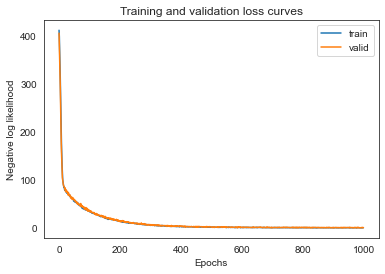

In [166]:
train_losses = history.history['loss']
valid_losses = history.history['val_loss']

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

In [167]:
names, samples = make_samples()

In [204]:
samples_nf = pd.DataFrame(scaler.inverse_transform(samples[0]).astype(np.int64),columns=X_test.columns)
samples_nf['Risk1Yr'] = y_train

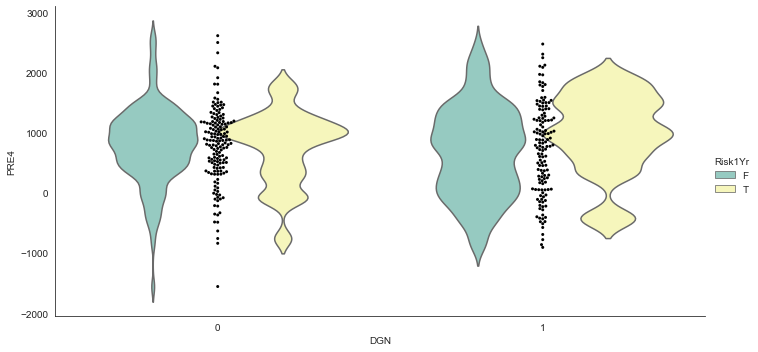

In [205]:
g = sns.catplot(x='DGN', y='PRE4', kind="violin", hue='Risk1Yr', data=samples_nf, inner=None, doge=True, palette='Set3', legend_out=True, aspect=2, bw=0.2, ci=95)
sns.swarmplot(x="DGN", y='PRE4', color="k", size=3, data=samples_nf, ax=g.ax)
sns.despine()